In [71]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator
from matplotlib import cm

import os
from tqdm import tqdm

In [72]:
from SAM_DataVisualize import SAM_DataVisualize

In [73]:
class SAM_DataProcess():
    def __init__(self):
        self.var = ['PW','CWP','TWP','ZC','TB']
        self.nc = None
        self.caseID = None
        self.path = '/data/xchen/SAM_LES_Orion'
             
    def block_averaging(self, nblock=64, domain_shape='square'):
        ds_2D = self.nc
        
        # add one extra column of grid point at the end due to periodic boundary condition (?)
        domain_size = np.max(ds_2D.x) - np.min(ds_2D.x) 
        
        # we know a priori that the domain is a square;
        nblock_per_side = np.sqrt(nblock)
        block_size = domain_size.values/nblock_per_side

        # we also know that the domain resolution is horizontally uniform
        dx = ds_2D.x[1] - ds_2D.x[0]
        dy = ds_2D.y[1] - ds_2D.y[0]

        # construct coodinate for the 64 blocks:
        xincs = np.int32(np.round(block_size/dx.values))
        n = np.arange(0, nblock_per_side, dtype=int)
        
        xidx_block = np.int8(np.zeros(np.shape(n), dtype=int) + n*xincs + xincs/2*np.ones(np.shape(n), dtype=int))
        yidx_block = xidx_block
        
        ds_sub= ds_2D.isel(x=xidx_block, y=yidx_block)
        
        #xidx_vtx = np.int8(np.zeros(np.shape(n), dtype=int) + n*xincs)
        #yidx_vtx = xidx_vtx

        #ds_vtx = ds_2D.isel(x=xidx_vtx, y=yidx_vtx)

        #x2d, y2d = np.meshgrid(ds_2D.x, ds_2D.y)
        #xb2d, yb2d = np.meshgrid(ds_sub.x, ds_sub.y)
        
        # average data point within each block;
        r = block_size/2
        ds_blockave = [None]*nblock
        cnt = 0
        for i in np.arange(nblock_per_side, dtype=int):
            for j in np.arange(nblock_per_side, dtype=int):        
                critx = (ds_2D.x>=ds_sub.x[i]-r) * (ds_2D.x<=ds_sub.x[i]+r)   # use math operator instead of and/or
                crity = (ds_2D.y>=ds_sub.y[j]-r) * (ds_2D.y<=ds_sub.y[j]+r)
                crit_block = critx * crity
                ds_tmp = ds_2D.where(crit_block, drop=True)

                # find block average for all the variables:
                # how to set up a new dimenion named block
                ds_blockave_tmp = ds_tmp.mean(dim=['x','y'])
                ds_blockave_tmp = ds_blockave_tmp.assign_coords(block=cnt)
                ds_blockave[cnt] = ds_blockave_tmp.expand_dims('block')
                cnt = cnt +1
                
        # combined all the blocks into one xarray dataset.
        ds_blkave = xr.combine_by_coords(ds_blockave)
        
        return ds_blkave
    
    
    def TWPsorted_quartile_statistics(self,TWP_bins=None, TWP_bin_labels=['Q1','Q2','Q3','Q4'] ):
        
        ds_blkave = self.nc
        
        # sort the blocks by TWP 
        #TWP_bins=np.percentile(ds_blkave.TWP, np.linspace(0,100,5))
        #TWP_bin_labels = ['Q1','Q2','Q3','Q4']
        
        ds_quartile_mean = [None]*len(ds_blkave.time)
        for ip in tqdm(range(10)):
            for it in np.arange(len(ds_blkave.time)):
                # get the time instance at current time:
                ds_blkave_tmp = ds_blkave.isel(time=it)

                # group blocks into four quartiles:
                TWP_bins=np.percentile(ds_blkave_tmp.TWP, np.linspace(0,100,5))
                ds_blkave_PW_grped = ds_blkave_tmp.groupby_bins('TWP', TWP_bins, 
                                                       labels=TWP_bin_labels).groups

                # compute the quartile averaged value for all variables:
                cnt=0
                ds_QN_mean = [None]*4
                for label, grpID in ds_blkave_PW_grped.items():
                    #print(label)
                    ds_QN = ds_blkave_tmp.isel(block=grpID)
                    # average over all the selected blocks:
                    ds_tmp =ds_QN.mean(dim='block')
                    ds_tmp = ds_tmp.assign_coords(quartile=label)
                    ds_QN_mean[cnt] = ds_tmp.expand_dims('quartile')
                    cnt=cnt+1

                ds_quartile_mean[it] = xr.combine_by_coords(ds_QN_mean)

        # concatenate data:
        ds_qrts = xr.concat(ds_quartile_mean, dim='time')
        return ds_qrts
    
    


In [9]:
# now try to test if the above class is working
# 1. establish the object and initialize it;
test = SAM_DataProcess()
CaseFolder = 'RICO_RRTM_3day'
test.path = os.path.join(test.path, CaseFolder)
test.caseID = 'RICO_RRTM_3day'



In [10]:
datafn = '/data/xchen/SAM_LES_Orion/RICO_RRTM_3day/OUT_2D/RICO_128x128x120_dx100m_standard_test_64.2Dcom_1.nc'
nc = xr.open_dataset(datafn)

# when the file is OUT_2D, add add total water path to the data
nc['TWP'] = nc.CWP + nc.IWP + nc.PW 
nc['logCWP'] = np.log10(nc.CWP)

# reset attribute for TWP and logCWP:
nc['TWP'] = nc.TWP.assign_attrs(long_name = 'Total Water Path')
nc['logCWP'] = nc.logCWP.assign_attrs(long_name='log10 Cloud Water Path')


/home/xchen/.conda/envs/eurec4a/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [11]:
test.nc = nc

In [12]:
# call into the block averaging and quartile sorted function/method
nblock=64 
ds_blockave_obj = test.block_averaging

In [13]:
ds_blockave=ds_blockave_obj()

In [14]:
TWP_bins=np.percentile(ds_blockave.TWP, np.linspace(0,100,5))
TWP_bin_labels = ['Q1','Q2','Q3','Q4']
test.nc = ds_blockave
ds_qrtave = test.TWPsorted_quartile_statistics(TWP_bins=TWP_bins, TWP_bin_labels = TWP_bin_labels)

100%|█████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.28s/it]


In [74]:
# establish a plotting class:
qrtds = SAM_DataVisualize()


In [79]:
filename = 'quartile_mean_ds_for_testing.nc'
ds_qrtave.to_netcdf(filename)

In [75]:
# initialize data
qrtds.nc = ds_qrtave
qrtds.var = ['PW','CWP','ZC']


/tmp/ipykernel_2125889/2376244623.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nt = np.int(2/dt)


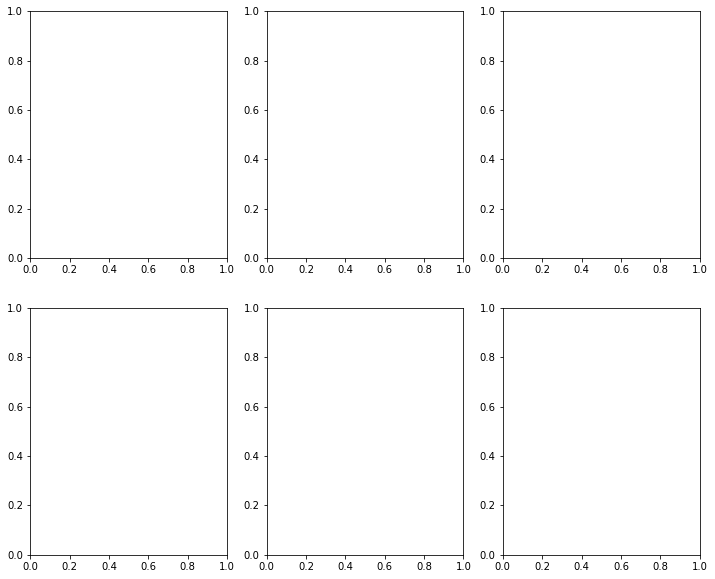

In [77]:
#varname=None, time_smoothing=False, time_smoothing_window=None,
dt = (nc.time[1]-nc.time[0])*24
nt = np.int(2/dt)
qrtds.quartile_evolution(varname=None)

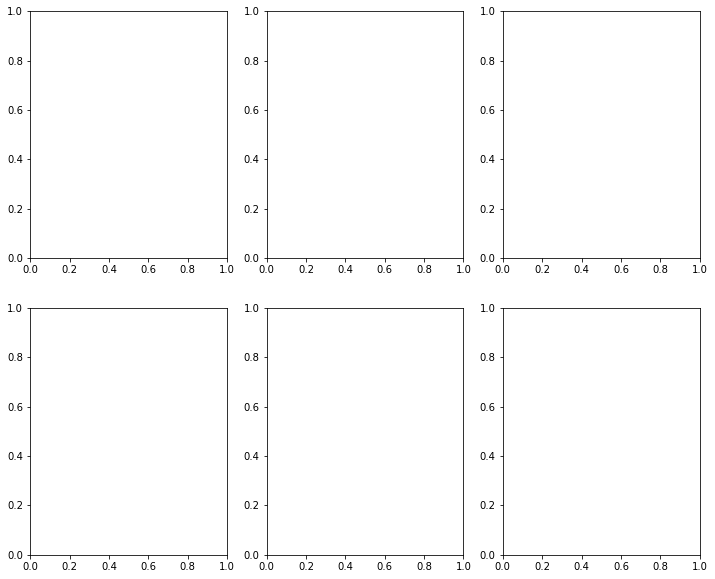

In [65]:
qrtds.quartile_evolution()

0 Q1
1 Q2
2 Q3
3 Q4


Text(0, 0.5, 'Precipitable Water(mm)\n quartile mean')

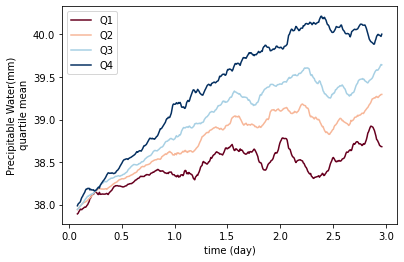

In [44]:
# now smooth the data using running mean;
def movmean(x, w):
    return np.convolve(x, np.ones(w), 'valid')/w

# try looking at other variables:
varn = 'PW'
colors=plt.cm.RdBu(np.linspace(0,1,4))

for i, key in enumerate(ds_qrtave.quartile.values):
    print(i, key)
    var = ds_qrtave.sel(quartile=key)[varn]
    meanvar = movmean(var, 12)
    meant = movmean(ds_qrtave.time, 12)
    plt.plot(meant, meanvar, color=colors[i], label=key)
plt.legend()
#plt.xlabel(ds_qrtave.time.long_name)
plt.xlabel(ds_qrtave.time.long_name +' (' +ds_qrtave.time.units +')')
# how to make sure that I get the attributes passed down to the xarray dataset: ds_qrtave???
plt.ylabel( nc[varn].long_name + '('+ nc[varn].units +')' +'\n quartile mean')


In [47]:
nc

<xarray.Dataset>
Dimensions:  (time: 427, x: 128, y: 128)
Coordinates:
  * x        (x) float32 0.0 100.0 200.0 300.0 ... 1.25e+04 1.26e+04 1.27e+04
  * y        (y) float32 0.0 100.0 200.0 300.0 ... 1.25e+04 1.26e+04 1.27e+04
  * time     (time) float32 0.04167 0.04861 0.05556 0.0625 ... 2.986 2.993 3.0
Data variables: (12/21)
    Prec     (time, y, x) float32 ...
    SHF      (time, y, x) float32 ...
    LHF      (time, y, x) float32 ...
    CWP      (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IWP      (time, y, x) float32 ...
    CLD      (time, y, x) float32 ...
    ...       ...
    V850     (time, y, x) float32 ...
    ZC       (time, y, x) float32 ...
    TB       (time, y, x) float32 ...
    ZE       (time, y, x) float32 ...
    TWP      (time, y, x) float32 37.78 37.84 37.88 37.9 ... 40.11 40.19 40.13
    logCWP   (time, y, x) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf